# 의료영상 U-Net 용종검출

- 실제 위내시경 이미지 데이터에서 용종부위를 검출하는 Polyp segmentation 태스크를 U-Net을 비롯한 다양한 모델을 통해 시도해 볼 것입니다. 이 과정을 통해서 의료영상을 처리할 때의 주의사항과 특이사항에 대해서도 경험하게 될 것입니다.

# 학습목표

- 위내시경 이미지에 용종을 표시한 데이터를 이용해 모델을 구성하고, 용종을 찾는 Segmentation 모델을 만들어 본다.
- 의료이미지 특성상 수가 적은 데이터셋을 활용하기 위한 Data augmentation을 진행해 본다.
- Encoder-Decoder Model과 U-net 모델을 구현해 보고, U-Net이 일반 Encoder-Decoder 모델 대비 어느정도 성능향상이 되는지 확인해 본다.
- U-Net에 pretrained encoder를 적용하여 성능개선을 확인해 본다.

# 평가 루브릭

- 아래의 기준을 바탕으로 프로젝트를 평가합니다.

- 평가문항	상세기준
    1. 의료영상 데이터의 전처리 및 augmentation을 위한 파이프라인 구성이 체계적으로 진행되었는가?: augmentation이 반영된 tf.data.Dataset 구성이 정상적으로 진행되었다.
    2. U-Net의 개선 모델을 구현하여 적용 후 기존 U-Net 대비 성능 개선을 확인하였는가?: U-Net 개선 모델의 학습 과정이 정상적으로 진행되었으며, validation meanIoU가 기존 U-Net보다 좋아짐을 확인하였다.
    3. 3가지 모델에 대한 학습과정, 테스트 결과를 체계적으로 비교분석하였는가?: loss 그래프, meanIoU 계산, segmentation 결과 시각화 등이 3가지 모델에 대해 수행된 후 결과 비교분석이 제시되었다.
    
# ★ 프로젝트: U-Net 성능 개선해 보기 ★ 
- 지금까지 우리는 Encoder-Decoder 모델과 U-Net 모델의 성능 차이를 실험을 통해 살펴보았습니다. 아마도 여러분들은 의료영상 Segmentation 모델을 위해 U-Net을 고려할 가치가 충분하다는 것을 확인할 수 있었을 것입니다.

- 그러나 이를 개선할 수 있는 방법 또한 무궁무진합니다. U-Net 또한 개선을 거듭해 왔고, 또 U-Net 기반이 아닌 다른 모델들도 많이 나오고 있습니다.

- 혹시, U-Net의 인코더 모델을 VGG, ResNet 등 기존의 pretrained model을 활용하는 것은 가능할까요? 또 그런 시도를 했을 때 성능 개선 효과가 있을까요?
- Pretrained model들은 ImageNet 데이터를 이용해 pretrain된 것이 대부분입니다. 일반적으로는 transfer learning이 훨씬 효과적인 것으로 알려져 있지만, 의료 영상 도메인에도 동일하게 효과적일까요? 오늘의 프로젝트는 그것을 확인해 보는 것으로 하겠습니다.

# 데이터 수집 및 Visualization

In [1]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.3.1


In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 데이터 수집 및 Visualization

In [3]:
DATASET_PATH=os.path.join(os.getenv('HOME'),'aiffel/medical')

if not os.path.isdir(DATASET_PATH):
    os.makedirs(DATASET_PATH)

import urllib.request
u = urllib.request.urlopen(url='https://aiffelstaticprd.blob.core.windows.net/media/documents/sd_train.zip')
data = u.read()
u.close()

with open('sd_train.zip', "wb") as f :
    f.write(data)
    print('Data has been downloaded')

#shutil.move(os.path.join('sd_train.zip'), os.path.join(DATASET_PATH))
file_path = os.path.join(DATASET_PATH, 'sd_train.zip')

import zipfile
zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall(DATASET_PATH)
zip_ref.close()
print('Data has been extracted.')

Data has been downloaded
Data has been extracted.


# Split dataset into train data and test data

In [4]:
img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [5]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [6]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [7]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 480
Number of test examples: 120


# Visualization

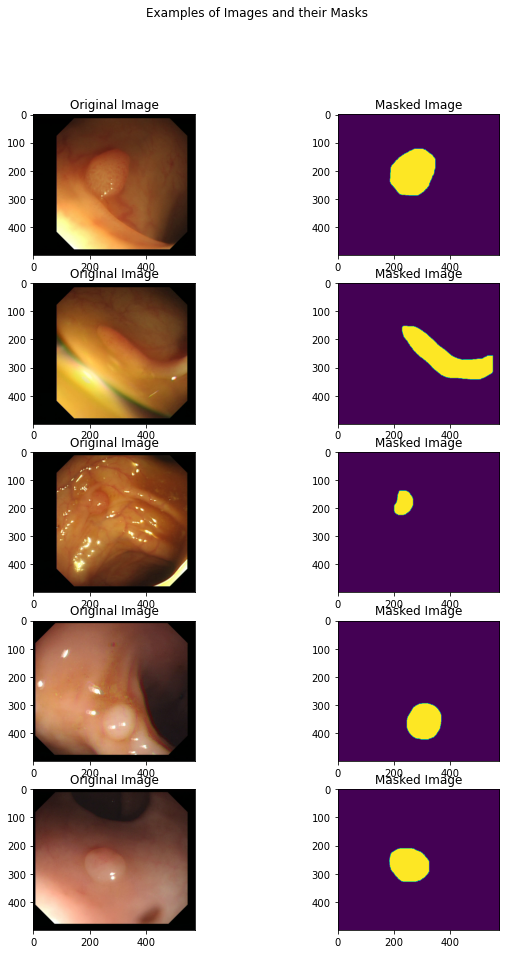

In [8]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

# Data pipeline and Preprocessing
## Set up hyper-parameters

In [9]:
# Set hyperparameters

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 50

# STEP 1 : 데이터셋 구성
- 오늘 실습에서 활용하였던 Giana 데이터셋을 그대로 활용하여, augmentation을 위한 파이프라인 구성 및 tf.data.Dataset을 이용한 배치처리를 통해 학습/테스트 데이터셋을 구성합니다.

# tf.data를 활용한 입력 파이프라인 설계


## Data augmentation의 필요성

    
## Processing each pathname

In [10]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3) # RGB

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=1) # BMP 0,1

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

## Data augmentation - Shifting the image

In [11]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

## Data augmentation - Flipping the image randomly

In [12]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

## Data augmentation Assembling

In [13]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

## Set up train and test datasets

In [14]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [15]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

In [56]:
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
test_dataset

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

# Plot some train data

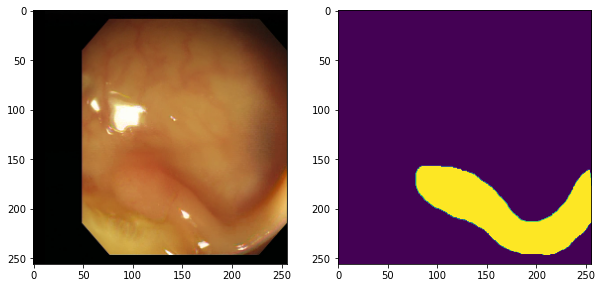

In [16]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

# Build the model


## Encoder-Decoder architecture

In [17]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [18]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

(8, 16, 16, 512)


In [19]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [20]:
# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

(8, 256, 256, 1)


## Create a encoder-decoder model

In [21]:
ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

# U-Net architecture

# Model subclassing을 활용한 구현

In [22]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [23]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [24]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

# STEP 2 : pretrained model을 활용한 U-Net 모델 구성
- Encoder를 pretrained 모델로 변경하는 작업을 어떻게 진행하면 좋을까요? 아래 예시는 VGG16을 활용하기 위한 것입니다. 마음에 드는 다른 모델을 활용하기 위해 다양하게 시도해 보는 것을 권장합니다.

- 우선 VGG16 모델의 레이어 구성을 확인해 봅시다. U-Net이란 Encoder와 Decoder 사이의 대응되는 레이어간의 skip connection이 특징인 모델입니다. 여기서 Encoder를 pretrained model로 바꿔주려면 Encoder로 활용할 모델의 레이어 구성을 눈여겨 봐야겠죠?

- VGG16의 경우 모델구성이 특히나 U-Net의 그것과 닮았다는 것을 알수 있습니다. 반드시 그래야 하는 것은 아니지만 이렇게 모델 구조가 유사하면 결합하여 사용하기에 유리할 것입니다.

- 아래는 VGG16을 Encoder로 활용하여 개선한 새로운 모델 클래스입니다. 이 모델을 구성하기 위해서 내부에서 새로운 모델(vgg16_act)을 만들었는데, 이것은 VGG16의 특정 레이어 출력을 가져와 Decoder와 연결하기 위한 것입니다. 기존 UNet 클래스와 비교하면, encoder 레이어가 없어지고 vgg16_act 모델의 출력이 그 역할을 대신하고 있음을 알수 있습니다.

In [25]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 
        
        center = self.center(center)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs

# Create a U-Net model

In [26]:
unet_model = UNet()

## metrics과 loss functions 정의하기

In [27]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [28]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [29]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [30]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

# STEP 3 : 학습과 테스트, 시각화
모델을 변경하여 실습과정과 동일하게 학습과 테스트, 시각화를 진행합니다.

# (1) Encoder-Decoder 모델

In [198]:
print('select the Encoder-Decoder model')
model = ed_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

select the Encoder-Decoder model


# Compile

In [199]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [200]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (8, 16, 16, 512)          4693056   
_________________________________________________________________
decoder (Sequential)         (8, 256, 256, 1)          2354913   
Total params: 7,047,969
Trainable params: 7,042,209
Non-trainable params: 5,760
_________________________________________________________________


# Callbacks

In [201]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 verbose=0)

In [36]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)


# Training - model.fit() 함수 이용

In [203]:
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 50
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )



Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/50
60/60 [==============================] - 9s 147ms/step - loss: 1.0962 - dice_loss: 0.7524 - val_loss: 1.8229 - val_dice_loss: 0.8706

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990134, shape=(), dtype=float32).
Epoch 2/50
60/60 [==============================] - 9s 146ms/step - loss: 0.9010 - dice_loss: 0.6733 - val_loss: 1.1896 - val_dice_loss: 0.7514

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009960574, shape=(), dtype=float32).
Epoch 3/50
60/60 [==============================] - 9s 147ms/step - loss: 0.8473 - dice_loss: 0.6413 - val_loss: 1.1457 - val_dice_loss: 0.7081

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009911436, shape=(), dtype=float32).
Epoch 4/50
60/60 [==============================] - 9s 145ms/step - loss: 0.7713 - dice_loss: 0.5847 - val_loss: 1.2813 - val_d


Epoch 00032: LearningRateScheduler reducing learning rate to tf.Tensor(0.0003159377, shape=(), dtype=float32).
Epoch 32/50
60/60 [==============================] - 9s 149ms/step - loss: 0.1008 - dice_loss: 0.0729 - val_loss: 0.1541 - val_dice_loss: 0.1137

Epoch 00033: LearningRateScheduler reducing learning rate to tf.Tensor(0.00028711034, shape=(), dtype=float32).
Epoch 33/50
60/60 [==============================] - 9s 157ms/step - loss: 0.0982 - dice_loss: 0.0716 - val_loss: 0.1248 - val_dice_loss: 0.0917

Epoch 00034: LearningRateScheduler reducing learning rate to tf.Tensor(0.0002591231, shape=(), dtype=float32).
Epoch 34/50
60/60 [==============================] - 9s 158ms/step - loss: 0.0913 - dice_loss: 0.0662 - val_loss: 0.1350 - val_dice_loss: 0.1007

Epoch 00035: LearningRateScheduler reducing learning rate to tf.Tensor(0.00023208655, shape=(), dtype=float32).
Epoch 35/50
60/60 [==============================] - 9s 152ms/step - loss: 0.0856 - dice_loss: 0.0613 - val_loss: 0

# Plot the loss
- 저장된 학습 진행과정(history)을 시각화해 봅시다.

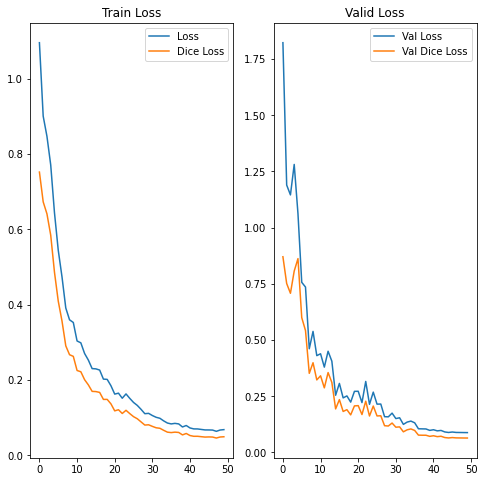

In [205]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

# Restore the latest checkpoint
- 저장된 모델의 가중치를 불러옵니다.

In [206]:
# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

# Evaluate the test dataset

In [49]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)
    

- 테스트 데이터셋을 불러와서 meanIoU 값을 구해 봅시다. 이 값이 우리가 훈련시킨 모델에 대한 정량적 성능 metric이 됩니다.


In [208]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.9190866245187982


- Test Dataset 내에 데이터들을 얼만큼 잘 맞추었는지 직접 확인해 봅시다.

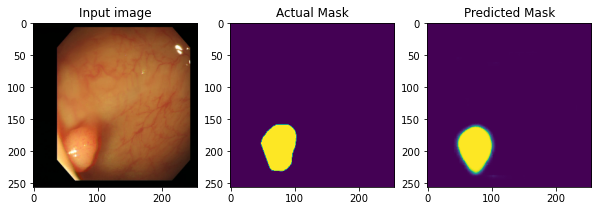

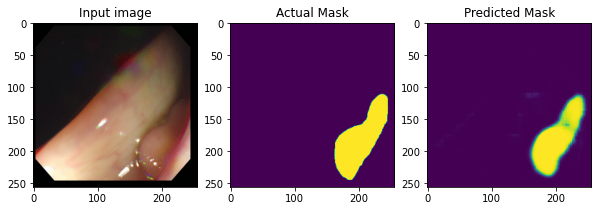

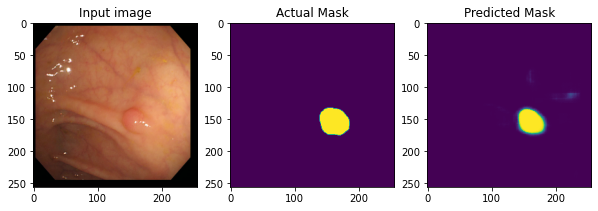

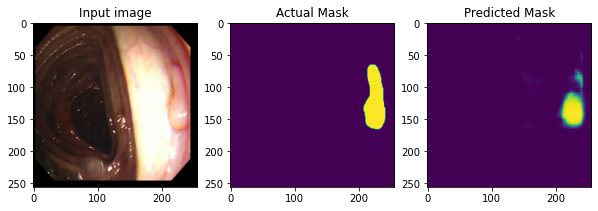

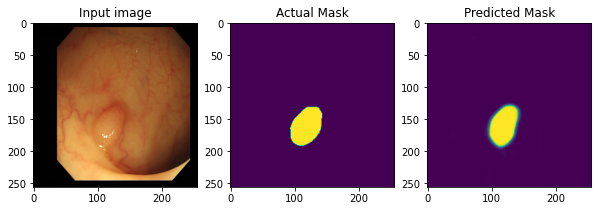

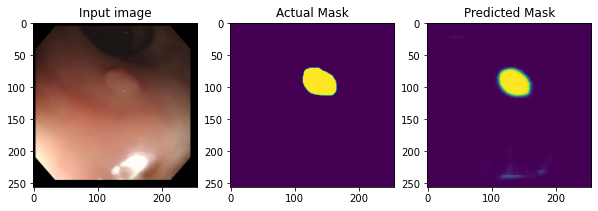

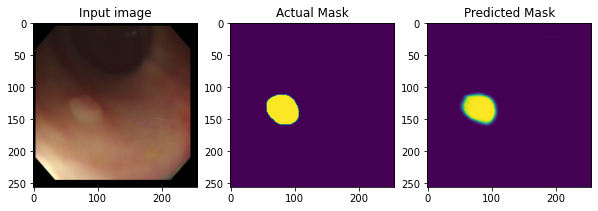

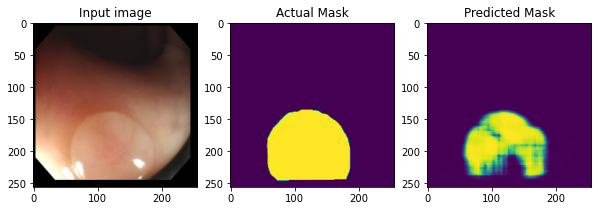

In [209]:
print_images()

# (2) U-Net 모델

In [29]:
print('select the U-Net model')
model = unet_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/unet_model')

select the U-Net model


# Compile

In [30]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [31]:
model.summary()

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  76416     
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  1773312   
_________________________________________________________________
encoder_block_3 (EncoderBloc multiple                  7085568   
_________________________________________________________________
conv_block_4 (ConvBlock)     multiple                  28326912  
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  18882048  
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  354278

# Callbacks

In [32]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [33]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

# Train your model

In [61]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

# Training - model.fit() 함수 이용

In [35]:
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 50
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/50
60/60 [==============================] - 45s 743ms/step - loss: 1.0206 - dice_loss: 0.7134 - val_loss: 14.1085 - val_dice_loss: 0.9684

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990134, shape=(), dtype=float32).
Epoch 2/50
60/60 [==============================] - 44s 738ms/step - loss: 0.9168 - dice_loss: 0.6971 - val_loss: 1.1883 - val_dice_loss: 0.8844

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009960574, shape=(), dtype=float32).
Epoch 3/50
60/60 [==============================] - 42s 705ms/step - loss: 0.8475 - dice_loss: 0.6461 - val_loss: 3.5037 - val_dice_loss: 1.0000

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009911436, shape=(), dtype=float32).
Epoch 4/50
60/60 [==============================] - 47s 777ms/step - loss: 0.7581 - dice_loss: 0.5782 - val_loss: 1.0668 - 

# Plot the loss

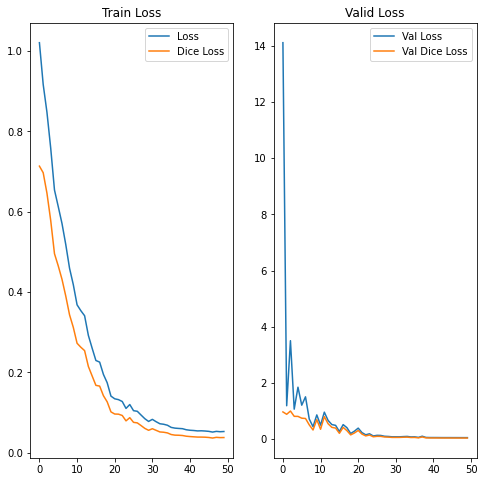

In [37]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

# Restore the latest checkpoint

In [38]:
# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

# Evaluate the test dataset

- 테스트 데이터셋을 불러와서 meanIoU 값을 구해 봅시다. 이 값이 우리가 훈련시킨 모델에 대한 정량적 성능 metric이 됩니다.

In [40]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.9443964060708974


- Test Dataset 내에 데이터들을 얼만큼 잘 맞추었는지 직접 확인해 봅시다.

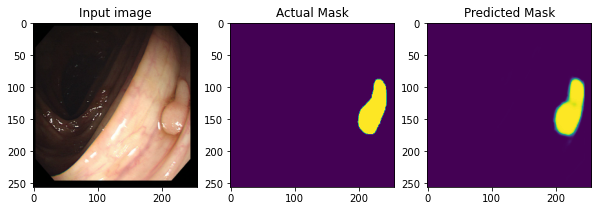

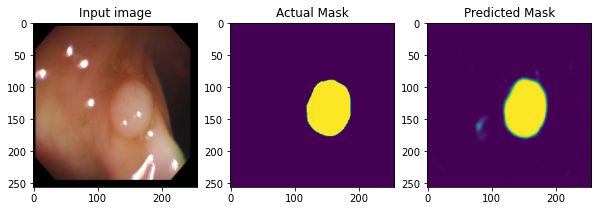

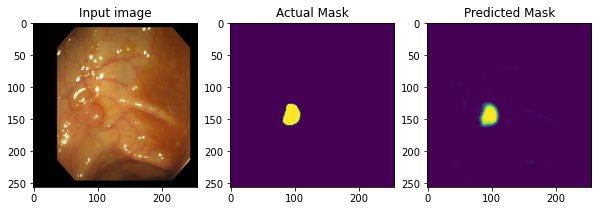

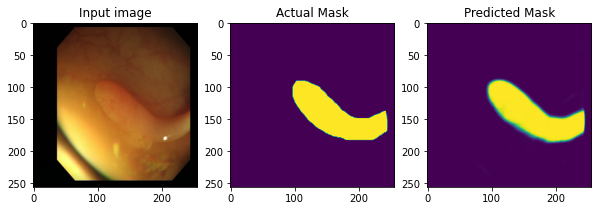

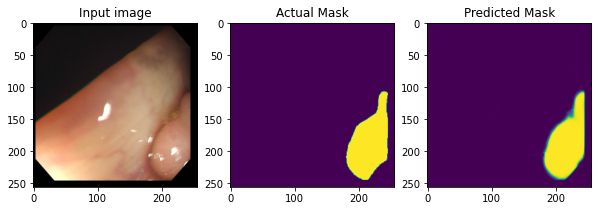

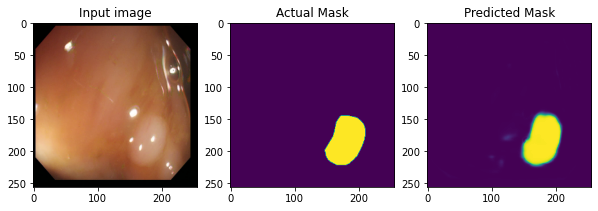

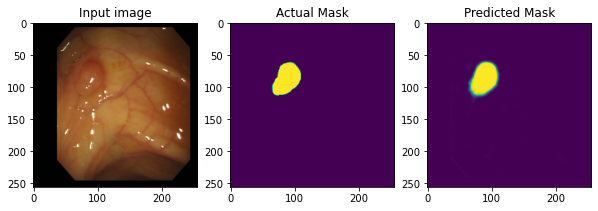

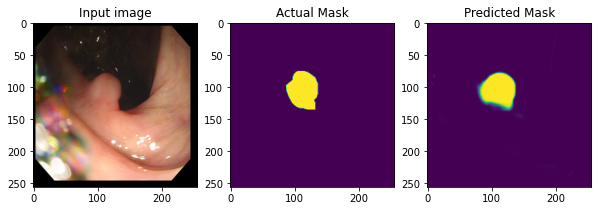

In [42]:
print_images()

# (3) Pretrained U-Net 모델

# Create a Vgg16UNet model
- 위에서 구현한 Class들을 생성해 최종적으로 Pretrained Vgg16 U-net 모델을 구현해 줍시다.

In [37]:
vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
layer_outputs = [layer.output for layer in vgg16.layers]
layer_outputs

[<tf.Tensor 'input_3:0' shape=(None, 256, 256, 3) dtype=float32>,
 <tf.Tensor 'block1_conv1/Relu_2:0' shape=(None, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'block1_conv2/Relu_2:0' shape=(None, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'block1_pool/MaxPool_2:0' shape=(None, 128, 128, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1/Relu_2:0' shape=(None, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'block2_conv2/Relu_2:0' shape=(None, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'block2_pool/MaxPool_2:0' shape=(None, 64, 64, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1/Relu_2:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_conv2/Relu_2:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_conv3/Relu_2:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_pool/MaxPool_2:0' shape=(None, 32, 32, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1/Relu_2:0' shape=(None, 32, 32, 512) dtype=float32>,
 <tf.Tensor 'block4_conv2/Relu_2:0' shape=(None, 32, 32, 512) d

In [38]:
vgg16unet_model = Vgg16UNet()

In [39]:
print('select the Pretrained vgg16unet_model')
model = vgg16unet_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/vgg16unet_model')

select the Pretrained vgg16unet_model


# Compile

In [40]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [41]:
model.summary()

Model: "vgg16u_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
functional_3 (Functional)    [(None, 256, 256, 64), (N 14714688  
_________________________________________________________________
conv_block_6 (ConvBlock)     multiple                  23608320  
_________________________________________________________________
decoder_block_8 (DecoderBloc multiple                  16522752  
_________________________________________________________________
decoder_block_9 (DecoderBloc multiple                  2952960   
_________________________________________________________________
decoder_block_10 (DecoderBlo multiple                  739200    
_________________________________________________________________
decoder_block_11 (DecoderBlo multiple                 

# Callbacks

In [42]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [43]:
cos_decay = tf.keras.experimental.CosineDecay(1e-4, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

# Training - model.fit() 함수 이용

In [44]:
max_epochs = 100
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 50
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )



Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(1e-04, shape=(), dtype=float32).
Epoch 1/100
60/60 [==============================] - 32s 526ms/step - loss: 0.8725 - dice_loss: 0.5612 - val_loss: 1.0084 - val_dice_loss: 0.6753

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(9.9901335e-05, shape=(), dtype=float32).
Epoch 2/100
60/60 [==============================] - 31s 514ms/step - loss: 0.3787 - dice_loss: 0.2413 - val_loss: 0.7689 - val_dice_loss: 0.4518

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(9.9605735e-05, shape=(), dtype=float32).
Epoch 3/100
60/60 [==============================] - 27s 453ms/step - loss: 0.2698 - dice_loss: 0.1685 - val_loss: 0.8916 - val_dice_loss: 0.4307

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(9.911435e-05, shape=(), dtype=float32).
Epoch 4/100
60/60 [==============================] - 31s 511ms/step - loss: 0.2245 - dice_loss: 0.1393 - val_loss: 0.46

60/60 [==============================] - 32s 528ms/step - loss: 0.0447 - dice_loss: 0.0259 - val_loss: 0.0534 - val_dice_loss: 0.0314

Epoch 00031: LearningRateScheduler reducing learning rate to tf.Tensor(3.454914e-05, shape=(), dtype=float32).
Epoch 31/100
60/60 [==============================] - 33s 545ms/step - loss: 0.0434 - dice_loss: 0.0248 - val_loss: 0.0533 - val_dice_loss: 0.0311

Epoch 00032: LearningRateScheduler reducing learning rate to tf.Tensor(3.159377e-05, shape=(), dtype=float32).
Epoch 32/100
60/60 [==============================] - 32s 532ms/step - loss: 0.0419 - dice_loss: 0.0239 - val_loss: 0.0519 - val_dice_loss: 0.0306

Epoch 00033: LearningRateScheduler reducing learning rate to tf.Tensor(2.8711032e-05, shape=(), dtype=float32).
Epoch 33/100
60/60 [==============================] - 31s 517ms/step - loss: 0.0414 - dice_loss: 0.0238 - val_loss: 0.0510 - val_dice_loss: 0.0298

Epoch 00034: LearningRateScheduler reducing learning rate to tf.Tensor(2.5912308e-05, s

60/60 [==============================] - 28s 473ms/step - loss: 0.0337 - dice_loss: 0.0186 - val_loss: 0.0487 - val_dice_loss: 0.0286

Epoch 00063: LearningRateScheduler reducing learning rate to tf.Tensor(0.0, shape=(), dtype=float32).
Epoch 63/100
60/60 [==============================] - 29s 481ms/step - loss: 0.0336 - dice_loss: 0.0184 - val_loss: 0.0487 - val_dice_loss: 0.0285

Epoch 00064: LearningRateScheduler reducing learning rate to tf.Tensor(0.0, shape=(), dtype=float32).
Epoch 64/100
60/60 [==============================] - 31s 510ms/step - loss: 0.0340 - dice_loss: 0.0187 - val_loss: 0.0487 - val_dice_loss: 0.0285

Epoch 00065: LearningRateScheduler reducing learning rate to tf.Tensor(0.0, shape=(), dtype=float32).
Epoch 65/100
60/60 [==============================] - 31s 525ms/step - loss: 0.0338 - dice_loss: 0.0186 - val_loss: 0.0487 - val_dice_loss: 0.0285

Epoch 00066: LearningRateScheduler reducing learning rate to tf.Tensor(0.0, shape=(), dtype=float32).
Epoch 66/100


60/60 [==============================] - 28s 459ms/step - loss: 0.0343 - dice_loss: 0.0191 - val_loss: 0.0487 - val_dice_loss: 0.0285

Epoch 00096: LearningRateScheduler reducing learning rate to tf.Tensor(0.0, shape=(), dtype=float32).
Epoch 96/100
60/60 [==============================] - 28s 460ms/step - loss: 0.0341 - dice_loss: 0.0190 - val_loss: 0.0487 - val_dice_loss: 0.0285

Epoch 00097: LearningRateScheduler reducing learning rate to tf.Tensor(0.0, shape=(), dtype=float32).
Epoch 97/100
60/60 [==============================] - 28s 463ms/step - loss: 0.0336 - dice_loss: 0.0184 - val_loss: 0.0487 - val_dice_loss: 0.0285

Epoch 00098: LearningRateScheduler reducing learning rate to tf.Tensor(0.0, shape=(), dtype=float32).
Epoch 98/100
60/60 [==============================] - 28s 461ms/step - loss: 0.0334 - dice_loss: 0.0182 - val_loss: 0.0486 - val_dice_loss: 0.0285

Epoch 00099: LearningRateScheduler reducing learning rate to tf.Tensor(0.0, shape=(), dtype=float32).
Epoch 99/100


# Plot the loss
- 저장된 학습 진행과정(history)을 시각화해 봅시다.

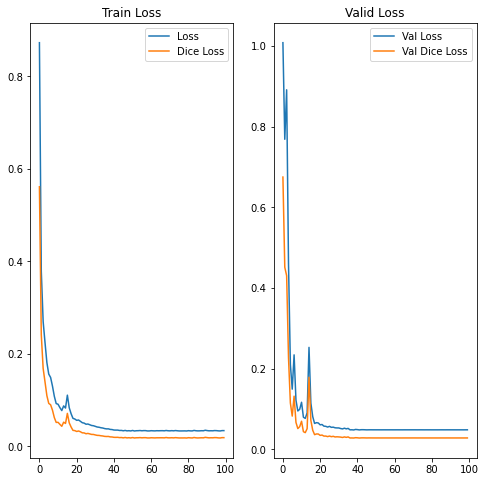

In [46]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

# Restore the latest checkpoint
- 저장된 모델의 가중치를 불러옵니다.

In [47]:
# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

# Evaluate the test dataset

- 테스트 데이터셋을 불러와서 meanIoU 값을 구해 봅시다. 이 값이 우리가 훈련시킨 모델에 대한 정량적 성능 metric이 됩니다.

In [50]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.9597180017107888


- Test Dataset 내에 데이터들을 얼만큼 잘 맞추었는지 직접 확인해 봅시다.

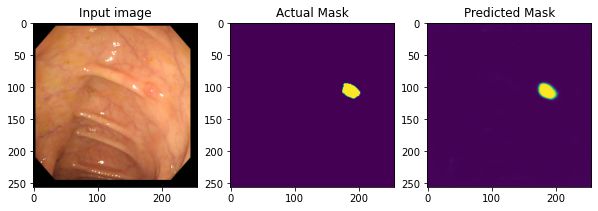

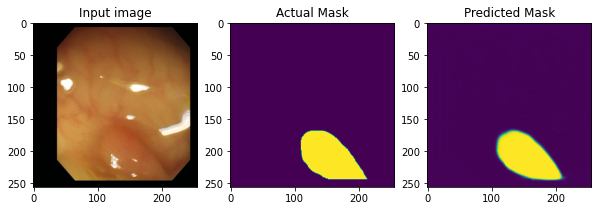

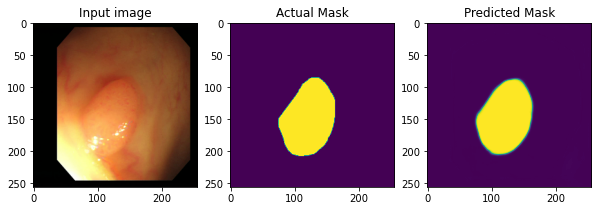

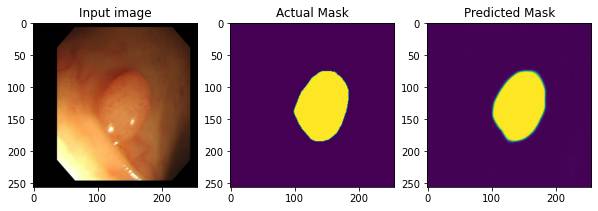

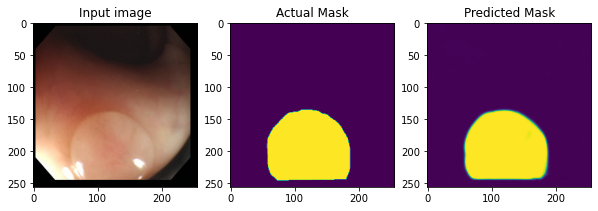

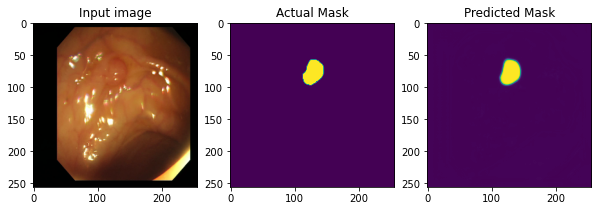

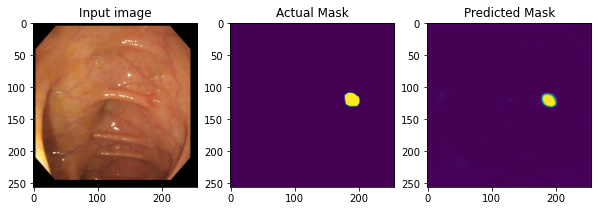

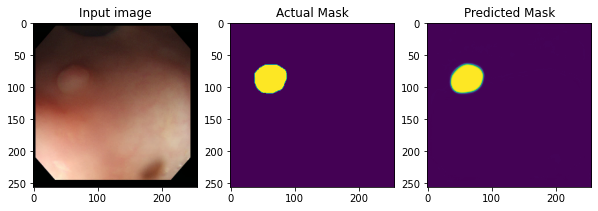

In [63]:
print_images()

# STEP 4 : 모델 성능 비교분석
Encoder-Decoder 모델, U-Net 모델, Pretrained U-Net 모델 이상 3가지에 대해 학습 진행과정, 정량/정성적 테스트 결과를 포함한 비교분석을 진행하여 봅니다.

# 결론: Encoder-Decoder 모델, U-Net 모델, Pretrained U-Net 모델 비교 분석

## (1) 총 파라미터 수
- Unet Model이 Vgg16 Unet Model과 Encoder_Decoder Model 보다 파라미터 수가 많다. 
    1. Encoder_Decoder Model: 7,047,969
    2. Unet Model:  61,240,193
    3. Vgg16 Unet Model: 58,723,265

## (2) 학습 결과
### : Vgg16 Unet Model >> Unet Model >> Encoder_Decoder Model

### 1. Encoder_Decoder Model
- loss: 0.0680, dice_loss: 0.0491, val_loss: 0.0882, ***val_dice_loss: 0.0641***

![title](ed_model.png)

### 2. Unet Model
- loss: 0.0531, dice_loss: 0.0381, val_loss: 0.0536, ***val_dice_loss: 0.0393***

![title](unet_model.png)

### 3. Vgg16 Unet Model
- loss: 0.0342, dice_loss: 0.0189, val_loss: 0.0487, ***val_dice_loss: 0.0285***

![title](vgg16unet_model.png)

## (2) mean IoU
### :  Vgg16 Unet Model이 Unet Model보다 0.154 높았고, Unet Model이 Encoder_Decoder Model 보다 0.253 높았다.
    1. Encoder_Decoder Model: ***0.9190***
    2. Unet Model: ***0.9443***
    3. Vgg16 Unet Model: ***0.9597***

### (3) 테스트 이미지 결과 분석

### 1. Encoder_Decoder Model
- 용종의 가장자리를 정확하게 세그멘테이션 하지 못했다. 

![title](ed_model_image.png)

### 2. Unet Model
- 대부분 세그멘테이션 결과가 나아졌지만, 일부는 용종의 가장자리를 정확하게 세그멘테이션 하지 못했다. 

![title](unet_model_image.png)

### 3. Vgg16 Unet Model
- 전체적으로 세그멘테이션 결과가 매우 정확해졌다. 

![title](vgg16unet_model_image.png)
